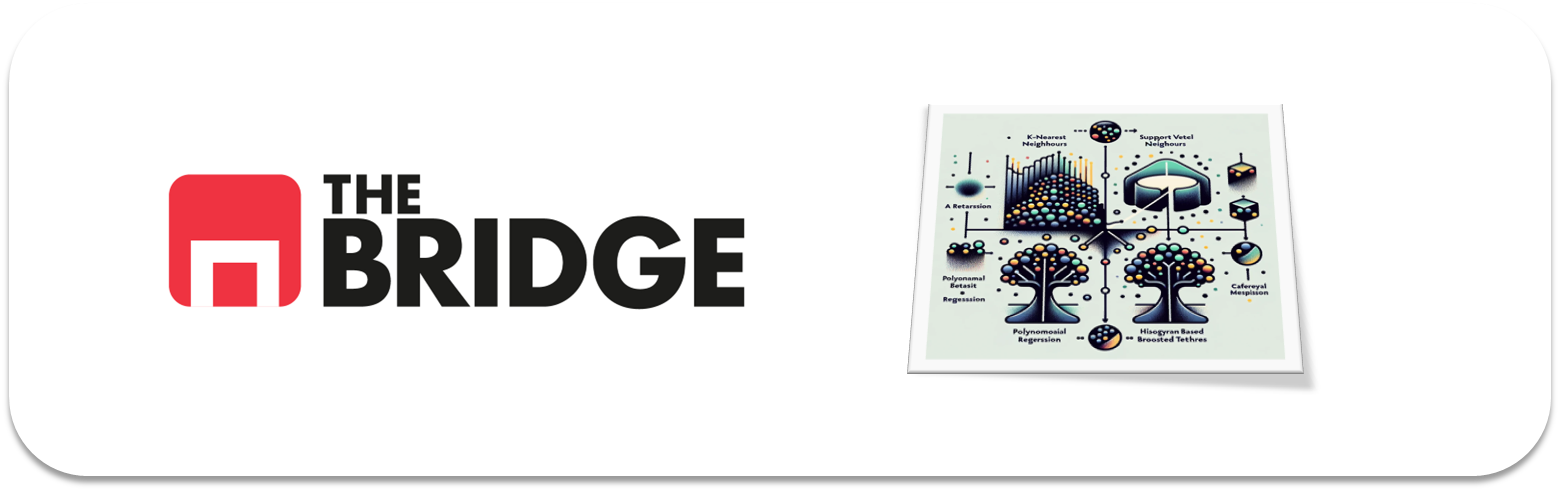

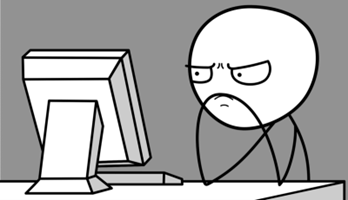

Para ejercitarte y afianzar lo aprendido sobre **Etapas Adicionales**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

### #1 Equilibrado de Datasets

### Ejercicio 1

Carga el dataset de los diamantes (está en el directorio "data") preparado ya para poder entrenar un modelo de clasificación. Muestra las primeras 7 filas y observa el listado de columnas. Muestra la distribución del potencial target ("cut") que ya conoces. ¿Está desbalanceada?

In [2]:
df = pd.read_csv("./data/diamonds_preparado.csv", sep = "|")

In [3]:
df.head(7)

,carat,cut,depth,table,price,x,y,z,color_D,color_E,...,color_I,color_J,clarity_IF,clarity_VVS1,clarity_VVS2,clarity_VS1,clarity_VS2,clarity_SI1,clarity_SI2,clarity_I1
0,0.23,Ideal,61.5,55.0,326,3.95,3.98,2.43,0,1,...,0,0,0,0,0,0,0,0,1,0
1,0.21,Premium,59.8,61.0,326,3.89,3.84,2.31,0,1,...,0,0,0,0,0,0,0,1,0,0
2,0.23,Good,56.9,65.0,327,4.05,4.07,2.31,0,1,...,0,0,0,0,0,1,0,0,0,0
3,0.29,Premium,62.4,58.0,334,4.20,4.23,2.63,0,0,...,1,0,0,0,0,0,1,0,0,0
4,0.31,Good,63.3,58.0,335,4.34,4.35,2.75,0,0,...,0,1,0,0,0,0,0,0,1,0
5,0.24,Very Good,62.8,57.0,336,3.94,3.96,2.48,0,0,...,0,1,0,0,1,0,0,0,0,0
6,0.24,Very Good,62.3,57.0,336,3.95,3.98,2.47,0,0,...,1,0,0,1,0,0,0,0,0,0


*Ya se ha hecho un one-hot encoding de algunas variables y las numéricas no se han escalado, pero no se va a necesitar*

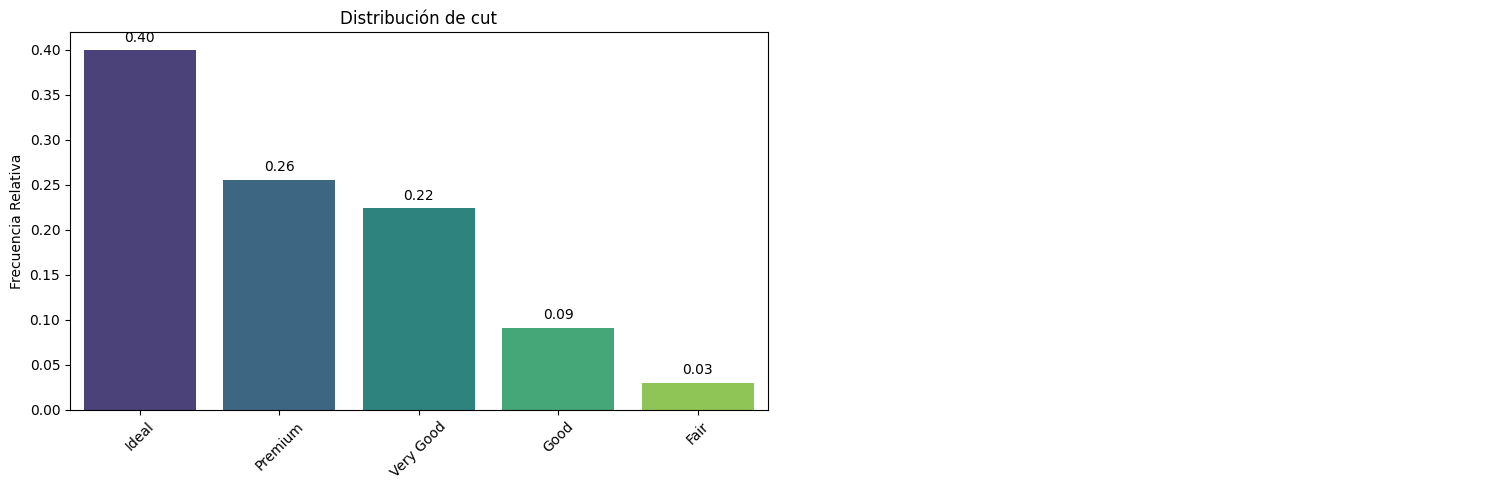

In [4]:
bt.pinta_distribucion_categoricas(df, ["cut"], mostrar_valores= True, relativa= True)

*Claramente desbalanceada, como ya sabíamos del workout*

 ### Ejercicio 2

 Crea un train_set y un test_set al 20%, crea los pares X,y de train y test con el target en la variable "cut", considera el resto como features.

In [5]:
target = "cut"

In [6]:
train_set, test_set = train_test_split(df, test_size =.2, random_state= 42)
X_train = train_set.drop(target, axis = 1)
y_train = train_set[target]
X_test = test_set.drop(target, axis = 1)
y_test = test_set[target]

### Ejercicio 3

Instancia un modelo RandomForest con max_depth a 5 y sin tocar otro hiperparámetro, entrénalo con el X_train y el y_train. Y muestra el classification_report para el X_train.

In [7]:
rf_clf = RandomForestClassifier(max_depth= 5, random_state= 42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

In [8]:
print(classification_report(y_train,rf_clf.predict(X_train)))

              precision    recall  f1-score   support

        Fair       0.89      0.66      0.76      1275
        Good       0.81      0.35      0.49      3902
       Ideal       0.78      0.94      0.85     17259
     Premium       0.59      0.87      0.70     11016
   Very Good       0.63      0.22      0.33      9700

    accuracy                           0.70     43152
   macro avg       0.74      0.61      0.63     43152
weighted avg       0.70      0.70      0.66     43152



*Incluso contra el train (es decir prediciendo a partir de los datos con los que ha entrenado) se ve que hay clases con las que no es capaz de trabajar adecuadamente. Fijate en las clases "Good" y "Very Good". Curiosamete no son las más minoritarias, "Fair" lo es pero no tiene malos números (bueno, ¿y qué son malos números? Depende de lo que nos diga negocio pero para que tengas una "idea" mental, todo lo que está entorno a 0.7 suele estar bien, pero no lo tomes como una regla de oro, solo como una guía). En el caso del train podemos hablar del 0.75-0.8 por debajo "underfitting", y siempre dependiendo del dataset*


### Ejercicio 4

Dado el desbalanceo, nos queremos fijar en el recall medio (la media del recall considerando cada clase). Usando "cross_val_score", hagamos una estimación un poco más precisa (y en general pesimista) de cual sería ese recall medio del modelo en general. Asigna para ello a `scoring` el valor `balanced_accuracy`

In [9]:
# balanced accuracy es la media de los recall
recall_medio = np.mean(cross_val_score(rf_clf, X_train, y_train, cv = 5, scoring = "balanced_accuracy"))

In [10]:
print("Recall medio con validación cruzada", recall_medio)

Recall medio con validación cruzada 0.6024255909998344


*Como puedes ver es sólo un poco menor que el recall medio probado contra train. ¿Qué quiere decir este valor? Este valor nos dice que en media somos capaces de etiquetar correctamente el 60% de cada clase. ¿Eso es bueno o malo? Depende, puede que quisieramos ser mejores en alguna clase en particular, entonces tendríamos que cambiar nuestra métrica de scoring para reflejarlo y así saber si estamos con un buen modelo o malo*

### Ejercicio 5

El resultado obtenido en el ejercicio 4 es bueno o malo dependiendo de lo que "Negocio" nos diga. Supón que negocio nos dice que quiere como mínimo que cada clase tenga un 50% de recall (que al menos un 50% de cada clase de diamente se etiquete bien por el modelo). Viendo el report anterior seguro que ves que así no llegamos. Tenemos que hacer algo, ayudar al modelo a conseguir ese objetivo. ¿Cómo? Con las téncias de equilibrado. Empecemos por aumentar las clases minoritarias con SMOTE. 

Crea un X_train y un y_train balanceados aplicando SMOTE; muestra el reparto del y_train para ver que se ha balanceado en todas las clases

In [11]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

y_train_smote.value_counts()

cut
Good         17259
Very Good    17259
Premium      17259
Ideal        17259
Fair         17259
Name: count, dtype: int64

### Ejercicio 6

Entrena con el nuevo X,y y muestra los resultados del modelo así entrenado pero prediciendo contra el X_test creado en el ejercicio 2. Comenta el resultado. NOTA: En el caso de querer balancear con tecnicas de Oversampling y Undersampling, es interesante crear un set de validación adicional al de test y train, para no tener que usar el test como validación de los modelos.

In [12]:
rf_clf_smote = RandomForestClassifier(max_depth= 5, random_state= 42)
rf_clf_smote.fit(X_train_smote, y_train_smote)
y_pred = rf_clf_smote.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        Fair       0.88      0.80      0.84       335
        Good       0.50      0.68      0.57      1004
       Ideal       0.77      0.94      0.85      4292
     Premium       0.61      0.82      0.70      2775
   Very Good       0.64      0.06      0.11      2382

    accuracy                           0.68     10788
   macro avg       0.68      0.66      0.61     10788
weighted avg       0.68      0.68      0.62     10788



*Aunque aparentemente hemos mejorado en casi todo y eso no está nada mal, ha sido a costa de Very Good, tendríamos que buscar una forma alternativa de resolver este problema. Quizás viendo hacia donde se van los Very Good e intentando hacer un modelo que corrija estos errores, o probando otros modelos.*

### Ejercicio 7

Prueba ahora a mejorar el modelo empleando el hiperparámetro class_weight. Reinstancia el modelo, entrenalo contra el X_train inicial y luego muestra el report contra el test. Comenta brevemente el resultado.

In [13]:
rf_clf_cw = RandomForestClassifier(max_depth= 5, class_weight= "balanced", random_state= 42)
rf_clf_cw.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=42)

In [14]:
y_pred = rf_clf_cw.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        Fair       0.88      0.84      0.86       335
        Good       0.49      0.71      0.58      1004
       Ideal       0.79      0.93      0.85      4292
     Premium       0.62      0.82      0.70      2775
   Very Good       0.62      0.06      0.11      2382

    accuracy                           0.69     10788
   macro avg       0.68      0.67      0.62     10788
weighted avg       0.68      0.69      0.63     10788



*Con esta técnica hemos conseguido mejorar el recall medio y algunos de los recalls por clase pero seguimos viendo el problema con "Very Good" que es una clase que se nos resiste*

### Ejercicio 8

Para terminar con nuestros intentos de mejorar la clasificación "global", vamos a aplicar el bajomuestreo de las clases mayoritarias, aunque no tengamos muchas esperanzas puestas en ello. Para poder hacerlo vamos a usar la clase `RandomUnderSampler` de la biblioteca imblearn. Investiga un poco sobre su funcionamiento (pista es equivalente en su uso a la clase Smote) y crea un dataset con undersampling de forma que las clases estén equilibradas. Muestra las frecuencias del target. ¿Por qué no tenemos muchas expectativas, en este caso, sobre esta técnica? 

*Veamos la distribución en el train del target*

In [15]:
y_train.value_counts()

cut
Ideal        17259
Premium      11016
Very Good     9700
Good          3902
Fair          1275
Name: count, dtype: int64

In [16]:
# Aplicar RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)

# Verificar el balance de clases después del undersampling
print("Distribución de clases después del undersampling:", pd.value_counts(y_res))


Distribución de clases después del undersampling: cut
Fair         1275
Good         1275
Ideal        1275
Premium      1275
Very Good    1275
Name: count, dtype: int64


C:\Users\Alberto Romero\AppData\Local\Temp\ipykernel_25340\2403889900.py:6: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print("Distribución de clases después del undersampling:", pd.value_counts(y_res))


*Hemos reducido notablemente nuestro dataset hasta que todas las clases tienen igual número de muestras que la minoritaria, y la reducción ha sido bastante importante, por eso tenemos pocas esperanzas pero... hay que probar*

### Ejercicio 9

Entrena, ahora con class_weight a None, un RandomForest como el inicial pero contra el train creado en el ejercicio 8, muestra su informe de clasificación sobre la predicción contra test y comenta el resultado.

In [17]:
rf_clf_us = RandomForestClassifier(max_depth= 5, random_state= 42)
rf_clf_us.fit(X_res, y_res)

RandomForestClassifier(max_depth=5, random_state=42)

In [18]:
y_pred = rf_clf_us.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        Fair       0.81      0.84      0.82       335
        Good       0.53      0.65      0.58      1004
       Ideal       0.79      0.92      0.85      4292
     Premium       0.61      0.85      0.71      2775
   Very Good       0.54      0.07      0.13      2382

    accuracy                           0.69     10788
   macro avg       0.66      0.67      0.62     10788
weighted avg       0.66      0.69      0.63     10788



*Resultados más o menos similares, mejores en nuestro objetivo que los obtenidos sin actuar sobre las clases minoritarias y mayoritaria, pero seguimos cayendo con "Very Good" (vaya ironía :-)*

### #2 Análisis de Errores

### Ejercicio 10

Muestra la matriz de confusión con "ConfusionMatrixDisplay.from_predictions" para el clasificador entrenado con el hiperparámetro class_weight con el valor "balanced" (el del ejercicio 7). Asigna el valor "true" (ojo es un string, no el booleano True) al argumento normalize. Comenta que estamos viendo y hacia donde se dirigen los errores de clasificación de "Very Good"

*Con el parámetro normalize a "true" la matriz que se pinta muestra los porcentajes de cada valor real repartidos en las etiquetas de predicción así la fila de Fair mostraría los porcentajes bien clasificados en la diagonal y para cada resto de casillas el porcentaje de diamantes Fair que han sido asignados a Good, Ideal, etc por el modelo*

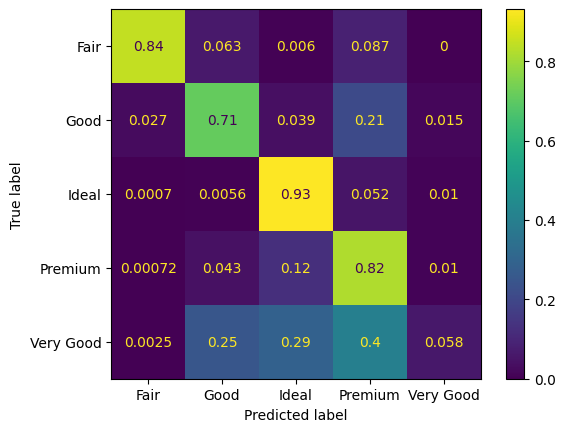

In [19]:
ConfusionMatrixDisplay.from_predictions(y_test, rf_clf_cw.predict(X_test), normalize= "true")

*Podemos observar que "Very Good" se reparte entre "Premium" (un 40% de las que deberían haberse etiquetado como Very Good se han etiquetado como "Premium"), "Ideal" (29%) y "Good" (25%). Una posible acción a realizar sería entender como poder mejorar la distinción entre "Premium" y "Very Good", ¿cómo podríamos ayudar al modelo a mejorar esta distinción?*

*Veamos además como se equivoca predicciendo "Premium" el modelo por si eso pudiera ayudarnos*

### Ejercicio 11

Muestra ahora la matriz de confusión, empleando la misma función, pero esta vez enseñando los porcentajes de distribució de los errores en la predicción, para eso emplea normalize = "pred" como argumeto y date cuenta de que las columnas son las que ahora suman el 100%. Comenta el resultado respecto a "Premium" como predicción y a lo que se equivoca respecto a "Very Good". 

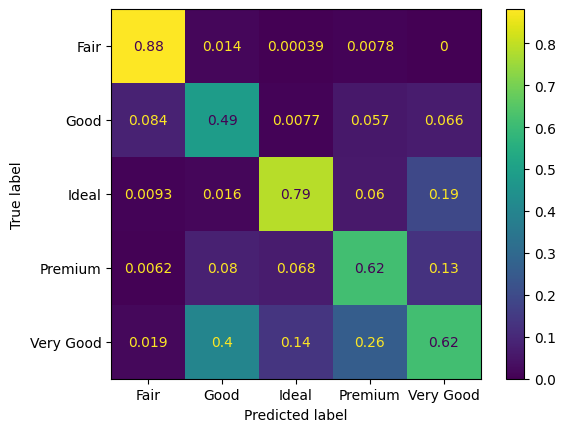

In [20]:
ConfusionMatrixDisplay.from_predictions(y_test, rf_clf_cw.predict(X_test), normalize= "pred")

*Curiosamente o no, el modelo cuando predice o etiqueta un diamante como "Premium" lo confunde con un "Very Good" el 26% de las veces y además es la etiqueta con la que más se confunde. Combinando el resultado del ejercicio anterior y este, parece claro que mejorar o ayudar en lo posible a que el modelo distinga mejor estas dos clases sería beneficiso para nuestros resultados globales (definidos por "Negocio") como para los particulares de la a clase "Premium". Una posible solución sería entrenar un modelo que actuase después del modelo ya entrenado y cuyo objetivo fuera actuar sobre los diamantes etiquetados por el primer modelo "Premium" para mejorar dicha etiquetación y solo la de esos diamantes, y con esa nueva etiqueta corregir la anterior solo de los premium. En este sentido, quizá probar un Gradient Boosted optimizado para el recall de "Very Good" dé mejor resultado*

### Ejercicio 12

Dada la relación entre los errores de "Very Good" y "Prediction" que puedes haber observado en los ejercicios anteriores, una posible mejora es introducir un modelo que corrija esos errores, pero esa es la filosofía de los Gradient Boosted Trees. Provemos esa línea: Entrena un CatBoost con los hiperparámetros ajustados para que no emplee más de 5 niveles en sus árboles intermedios y para que balanceé las clases.

1. Obtener el "balanced_accuracy" primero con una validación cruzada.
2. Evaluálo después de contra el test.

In [21]:
from catboost import CatBoostClassifier
cat_clf = CatBoostClassifier(max_depth= 5, verbose= False, auto_class_weights= "Balanced") # Esta es la forma que hay que configurar los hiperparámetros según el enunciado del ejercicio.


*Validación cruzada*

In [22]:
np.mean(cross_val_score(cat_clf, X_train, y_train, cv = 5, scoring="balanced_accuracy"))

0.7864038362819652

*El resultado de la validación cruzada es muy prometedor*

*Entrenemos contra todo el train y veamos el test*

In [23]:
cat_clf.fit(X_train, y_train)
y_pred = cat_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        Fair       0.87      0.93      0.90       335
        Good       0.70      0.80      0.74      1004
       Ideal       0.84      0.89      0.87      4292
     Premium       0.79      0.83      0.81      2775
   Very Good       0.69      0.53      0.60      2382

    accuracy                           0.79     10788
   macro avg       0.78      0.79      0.78     10788
weighted avg       0.78      0.79      0.78     10788



*Ahí lo tenemos hemos cumplido con los objetuvos de negocio completamente y con buena nota en casi todas las clases, salvo en "Very Good" donde por lo menos hemos aprobado*

*Es cierto que si hubieramos probado varios modelos también habríamos llegado a este resultado, y ese es uno de los motivos por el que se prueban y comparan varios modelos. Pero también es cierto que analizando los errores podemos llegar a probar cosas que no creíamos interesantes, como ha ocurrido en estos ejercicios*